In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [4]:
DATA_ROOT = Path('..') / 'data'

dfs = []
activity_labels = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activity_labels[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    
    # Add a column indicating order of the activities for a particiapnt.
    df = df.sort_values(by=['time'])
    df['activity_sequence'] = (df['activity'].shift(1) != df['activity']).cumsum()
    dfs.append(df)

sensor_df = pd.concat(dfs, axis='index')
sensor_df = sensor_df.sort_values(by=['participant', 'time'])

sensor_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,bed,M,d1p01M,1


### We need to get the length of consecutive sequences for each participant

#### Let's start with a single participant first!

In [5]:
mini = sensor_df[sensor_df['participant'] == 'd1p01M']

In [6]:
mini

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.42520,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.73690,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.03110,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.03710,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.89200,920.25,1,bed,M,d1p01M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,251.00,0.87003,0.46851,0.009122,4,-58.5,0.73631,921.75,1,bed,M,d1p01M,9
397,251.25,0.87003,0.46851,0.009122,1,-57.5,0.70870,923.25,1,bed,M,d1p01M,9
398,251.50,0.87003,0.46851,0.009122,1,-59.0,0.25157,924.75,1,bed,M,d1p01M,9
399,253.25,-0.00938,0.95081,-0.116310,1,-58.5,0.35282,924.25,1,bed,M,d1p01M,9


#### function to count data point in each sequence for a single participant

In [24]:
def count_datapoints(part):
    '''takes a dataframe and returns the number of datapoints, duration and sampling ratio for each type 
    of sequence. Code for grouping consecutive values into sequences adapted from here https://tinyurl.com/y6gab5fh'''
    
    p_data = []

    for _, v in mini.groupby((part['activity'].shift() != part['activity']).cumsum()):
        
        activity = v.activity.unique()[0]
        no_meas = len(v)
        dur = round(v.time.iloc[-1] - v.time.iloc[0], 3)
        if dur == 0.0:
            s_ratio = 0
        else:
            s_ratio = no_meas/dur
        
        p_data.append([activity, no_meas, dur, s_ratio ])
        
    p_df = pd.DataFrame(p_data, columns = ['activity_type', 'number_of_measurements', 'duration', 'sampling_ratio'])
        
    return p_df

In [25]:
p = count_datapoints(mini)

In [26]:
p.head()

,activity_type,number_of_measurements,duration,sampling_ratio
0,1,55,37.00,1.486486
1,3,117,36.50,3.205479
2,1,47,27.25,1.724771
3,4,4,7.50,0.533333
4,2,60,77.00,0.779221


#### now let's apply this to *all participants*

In [27]:
seq_df = sensor_df.groupby('participant').apply(count_datapoints).reset_index().drop(['level_1'], axis=1)

In [28]:
seq_df.head()

,participant,activity_type,number_of_measurements,duration,sampling_ratio
0,d1p01M,1,55,37.00,1.486486
1,d1p01M,3,117,36.50,3.205479
2,d1p01M,1,47,27.25,1.724771
3,d1p01M,4,4,7.50,0.533333
4,d1p01M,2,60,77.00,0.779221


#### How many sequences do we have to work with? 

In [178]:
seq_df.shape

(488, 4)

#### How many sequences for each activity type? 

In [36]:
seq_df.activity_type.value_counts()

1    244
3    185
2     50
4      9
Name: activity_type, dtype: int64

#### How many have only one sample point, and how many of those in each activity? 

In [35]:
print('single data point sequences:', len(seq_df.loc[seq_df['duration'] == 0.00]))
seq_df.loc[seq_df['duration'] == 0.00].activity_type.value_counts()

single data point sequences: 53


1    28
3    13
2    10
4     2
Name: activity_type, dtype: int64

### Quickest way to get a sense of what's going on with the data is still by plotting

What's the distribution of counts of sequences for all participants? 

In [37]:
part_s = seq_df.groupby('participant').describe()

In [38]:
part_s

activity_type                                               \
                    count      mean       std  min  25%  50%  75%  max   
participant                                                              
d1p01M                9.0  2.222222  1.301708  1.0  1.0  2.0  3.0  4.0   
d1p02M               11.0  1.727273  0.904534  1.0  1.0  1.0  2.5  3.0   
d1p03M                8.0  2.750000  0.707107  1.0  3.0  3.0  3.0  3.0   
d1p04M                8.0  2.500000  0.925820  1.0  2.5  3.0  3.0  3.0   
d1p05M                9.0  2.444444  0.881917  1.0  2.0  3.0  3.0  3.0   
...                   ...       ...       ...  ...  ...  ...  ...  ...   
d2p23F                9.0  1.888889  1.054093  1.0  1.0  1.0  3.0  3.0   
d2p24F                9.0  2.111111  1.054093  1.0  1.0  3.0  3.0  3.0   
d2p25F               11.0  1.727273  1.009050  1.0  1.0  1.0  3.0  3.0   
d2p26F               13.0  1.538462  0.877058  1.0  1.0  1.0  2.0  3.0   
d2p27F               12.0  2.000000  1.044466  1.0  1.0  2.0  3.0  3.0   

            number_of_measurements             ... duration           \
                             count       mean  ...      75%      max   
participant                                    ...                     
d1p01M                         9.0  44.555556  ...   37.000   77.000   
d1p02M                        11.0  23.636364  ...   24.375   49.250   
d1p03M                         8.0  41.000000  ...   22.500  146.375   
d1p04M                         8.0  50.125000  ...   39.950  130.250   
d1p05M                         9.0  44.555556  ...   44.250  102.250   
...                            ...        ...  ...      ...      ...   
d2p23F                         9.0  22.666667  ...    6.250   53.075   
d2p24F                         9.0  44.555556  ...    7.500  204.000   
d2p25F                        11.0  18.363636  ...    7.875   39.500   
d2p26F                        13.0  17.769231  ...    9.000   37.750   
d2p27F                        12.0  14.833333  ...   10.375   14.750   

            sampling_ratio                                                    \
                     count      mean       std       min       25%       50%   
participant                                                                    
d1p01M                 9.0  1.947607  1.361526  0.533333  0.800000  1.724771   
d1p02M                11.0  3.344058  3.547969  0.000000  1.527820  2.893617   
d1p03M                 8.0  2.862678  1.362625  1.134073  1.744048  2.895833   
d1p04M                 8.0  2.960121  1.814374  0.959693  1.757397  2.595020   
d1p05M                 9.0  1.870569  1.338253  0.000000  1.217391  1.807910   
...                    ...       ...       ...       ...       ...       ...   
d2p23F                 9.0  2.360976  1.411678  0.000000  1.750000  2.181818   
d2p24F                 9.0  3.804262  3.763116  1.317073  1.866667  2.352941   
d2p25F                11.0  3.586219  4.764857  0.000000  1.593974  2.000000   
d2p26F                13.0  1.945501  0.968627  0.000000  1.555556  1.866667   
d2p27F                12.0  2.968150  1.473208  1.217391  1.925000  2.601533   

                                  
                  75%        max  
participant                       
d1p01M       2.179894   4.819277  
d1p02M       3.535088  13.333333  
d1p03M       3.570136   5.333333  
d1p04M       3.376471   6.481481  
d1p05M       2.028169   4.819277  
...               ...        ...  
d2p23F       3.013699   5.000000  
d2p24F       3.725490  13.333333  
d2p25F       4.001183  17.142857  
d2p26F       2.780749   3.529412  
d2p27F       3.461039   6.000000  

[87 rows x 32 columns]

#### Get an idea of the distribution of numbers of sequences in all particpants


<AxesSubplot:>

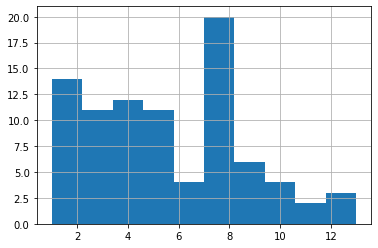

In [193]:
part_s['activity_type']['count'].hist()

### Get a histogram of number of measurements, durations & sampling_rate for types of activity

reminder: activity_labels = ['bed', 'chair', 'lying', 'ambulating']

<AxesSubplot:>

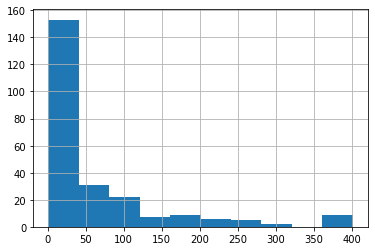

In [44]:
seq_df[seq_df['activity_type'] == 1]['number_of_measurements'].hist()

<AxesSubplot:>

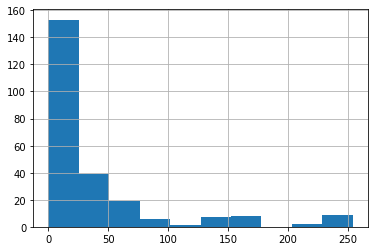

In [45]:
seq_df[seq_df['activity_type'] == 1]['duration'].hist()

<AxesSubplot:>

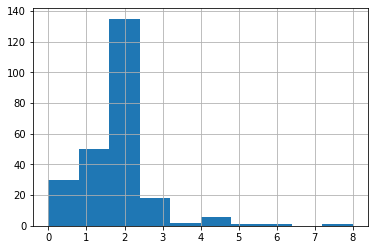

In [46]:
seq_df[seq_df['activity_type'] == 1]['sampling_ratio'].hist()

#### Descriptives by activity type

In [39]:
a_desc = seq_df.groupby('activity_type').describe()

a_desc

number_of_measurements                                        \
                               count       mean        std  min  25%   50%   
activity_type                                                                
1                              244.0  59.676230  93.508817  1.0  4.0  12.0   
2                               50.0  49.620000  63.347725  1.0  2.0  11.0   
3                              185.0  39.270270  58.465453  1.0  4.0  11.0   
4                                9.0  55.111111  75.118980  1.0  3.0   9.0   

                             duration             ...                   \
                  75%    max    count       mean  ...      75%     max   
activity_type                                     ...                    
1               77.75  401.0    244.0  35.919693  ...  43.0625  254.00   
2              116.00  176.0     50.0  37.959200  ...  85.0625  136.00   
3               52.00  306.0    185.0  20.631000  ...  19.5000  204.00   
4               72.00  181.0      9.0  52.475556  ...  94.2800  147.25   

              sampling_ratio                                               \
                       count      mean       std  min       25%       50%   
activity_type                                                               
1                      244.0  1.768555  0.976207  0.0  1.496622  1.752487   
2                       50.0  1.312466  1.271421  0.0  0.731748  1.333333   
3                      185.0  3.631872  3.535165  0.0  2.000000  2.857143   
4                        9.0  0.650487  0.453749  0.0  0.444444  0.763683   

                                    
                    75%        max  
activity_type                       
1              2.100840   8.000000  
2              1.451270   8.000000  
3              4.000000  25.000000  
4              0.857143   1.229202  

[4 rows x 24 columns]

#### Descriptives for activity type by participant

In [40]:
pa_desc = seq_df.groupby(['participant', 'activity_type']).describe().reset_index()

pa_desc

participant activity_type number_of_measurements                         \
                                               count        mean        std   
0        d1p01M             1                    4.0   28.500000  26.236107   
1        d1p01M             2                    1.0   60.000000        NaN   
2        d1p01M             3                    2.0  110.000000   9.899495   
3        d1p01M             4                    2.0    3.500000   0.707107   
4        d1p02M             1                    6.0   31.000000  24.576411   
..          ...           ...                    ...         ...        ...   
170      d2p26F             1                    9.0   22.111111  28.576408   
171      d2p26F             2                    1.0    1.000000        NaN   
172      d2p26F             3                    3.0   10.333333   6.429101   
173      d2p27F             1                    6.0   16.000000  15.019987   
174      d2p27F             3                    6.0   13.666667   9.993331   

                                          ... duration         sampling_ratio  \
       min     25%    50%     75%    max  ...      75%     max          count   
0      4.0    7.00   27.5   49.00   55.0  ...  29.6875  37.000            4.0   
1     60.0   60.00   60.0   60.00   60.0  ...  77.0000  77.000            1.0   
2    103.0  106.50  110.0  113.50  117.0  ...  44.5625  47.250            2.0   
3      3.0    3.25    3.5    3.75    4.0  ...   6.5625   7.500            2.0   
4      2.0   11.25   37.5   39.75   66.0  ...  25.9375  49.250            6.0   
..     ...     ...    ...     ...    ...  ...      ...     ...            ...   
170    3.0    9.00   12.0   14.00   95.0  ...  10.2500  37.750            9.0   
171    1.0    1.00    1.0    1.00    1.0  ...   0.0000   0.000            1.0   
172    3.0    8.00   13.0   14.00   15.0  ...   4.8500   5.025            3.0   
173    3.0    8.25   11.5   16.25   45.0  ...  11.1250  14.750            6.0   
174    4.0    8.00   11.0   15.50   32.0  ...   4.3375  11.600            6.0   

                                                                           
         mean       std       min       25%       50%       75%       max  
0    2.507634  1.555314  1.486486  1.665200  1.862385  2.704819  4.819277  
1    0.779221       NaN  0.779221  0.779221  0.779221  0.779221  0.779221  
2    2.692687  0.725198  2.179894  2.436290  2.692687  2.949083  3.205479  
3    0.666667  0.188562  0.533333  0.600000  0.666667  0.733333  0.800000  
4    2.247920  1.182810  0.791878  1.449624  2.162105  2.910000  4.000000  
..        ...       ...       ...       ...       ...       ...       ...  
170  1.777364  0.605426  0.874172  1.555556  1.750000  2.000000  3.006329  
171  0.000000       NaN  0.000000  0.000000  0.000000  0.000000  0.000000  
172  3.098412  0.386986  2.780749  2.882912  2.985075  3.257243  3.529412  
173  2.578040  1.791758  1.217391  1.550000  1.850000  2.788136  6.000000  
174  3.358261  1.095040  2.388060  2.522989  2.950739  4.097403  5.000000  

[175 rows x 26 columns]